# Importing Necessary Libraries

In [ ]:
# Import Required Libraries
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report


# Dataset Loading

In [ ]:
# Dataset Loading
(ds_train, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.T92NZC_0.1.0/beans-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.T92NZC_0.1.0/beans-validation.tfrecord*...:   0%|        …

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/incomplete.T92NZC_0.1.0/beans-test.tfrecord*...:   0%|          | 0/…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_dir=PosixGPath('/tmp/tmpb0zkcxi_tfds'),
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        'train': <SplitInf

# Data Preprocessing

In [ ]:
# Data Preprocessing
IMG_SIZE = 224  # MobileNet standard input size
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1] range
    return image, label

ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Data Visualization

<Figure size 1000x1000 with 0 Axes>

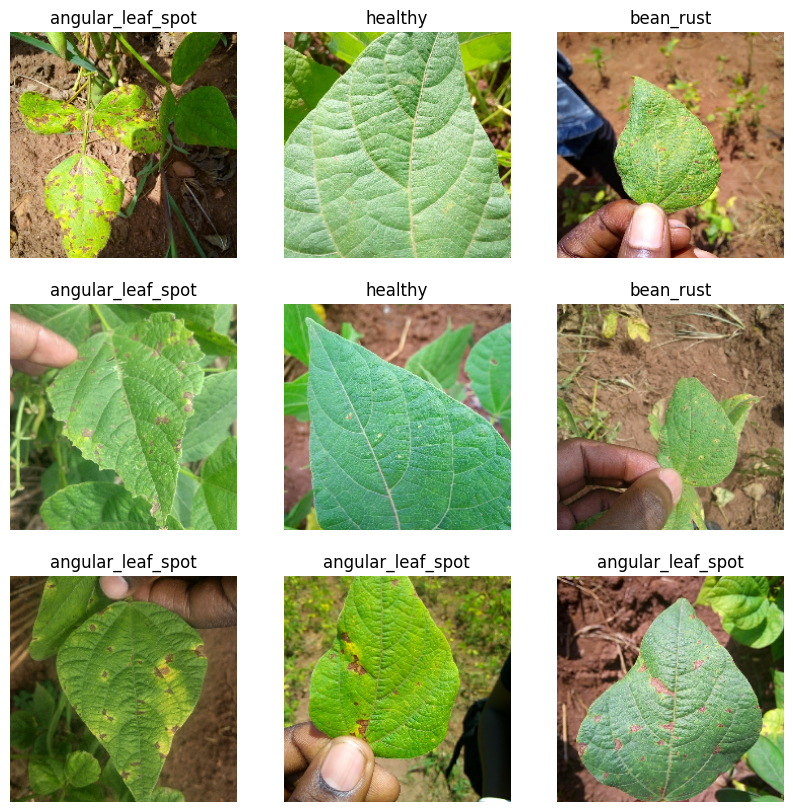

In [ ]:
# Data Visualization
class_names = ds_info.features['label'].names
plt.figure(figsize=(10, 10))
# Unbatch the dataset for visualization and shuffle it
ds_train_unbatched = ds_train.unbatch().shuffle(buffer_size=1000)

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train_unbatched.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(class_names[label.numpy()])
    plt.axis("off")
plt.show()

# Model Setup for Transfer Learning

In [ ]:
# Model setup for transfer learning
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add new classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Apply Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Training The Model

In [ ]:
# Training the Model
history = model.fit(ds_train, epochs=10, validation_data=ds_test, callbacks=[early_stopping])


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 0.6426 - loss: 0.8431 - val_accuracy: 0.8594 - val_loss: 0.3433
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.9123 - loss: 0.2475 - val_accuracy: 0.8359 - val_loss: 0.3184
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9400 - loss: 0.1715 - val_accuracy: 0.8828 - val_loss: 0.2668
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9527 - loss: 0.1360 - val_accuracy: 0.8984 - val_loss: 0.2917
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9719 - loss: 0.0839 - val_accuracy: 0.8984 - val_loss: 0.2346
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9914 - loss: 0.0558 - val_accuracy: 0.9062 - val_loss: 0.2423
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9939 - loss: 0.0452 - val_accuracy: 0.9062 - val_loss: 0.2360
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9977 - loss: 0.0374 - val_accuracy: 0.9062 -

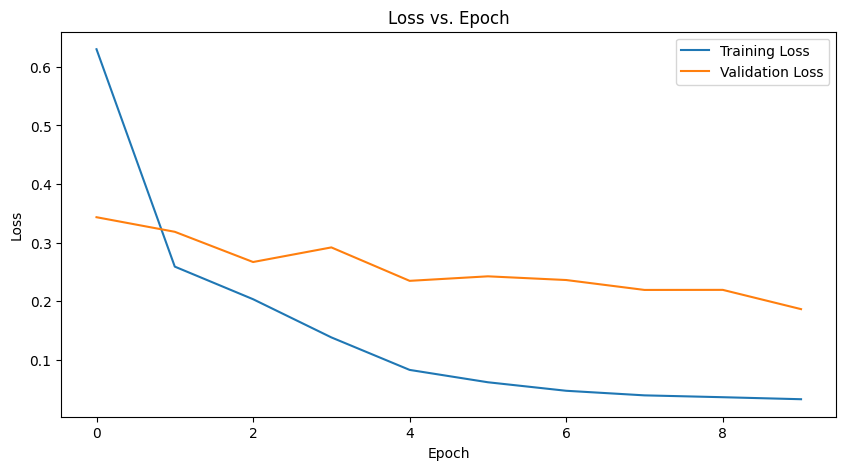

In [ ]:
# Plot Loss vs. Epoch
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Predict on the Test Data
test_images, test_labels = next(iter(ds_test))
predictions = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


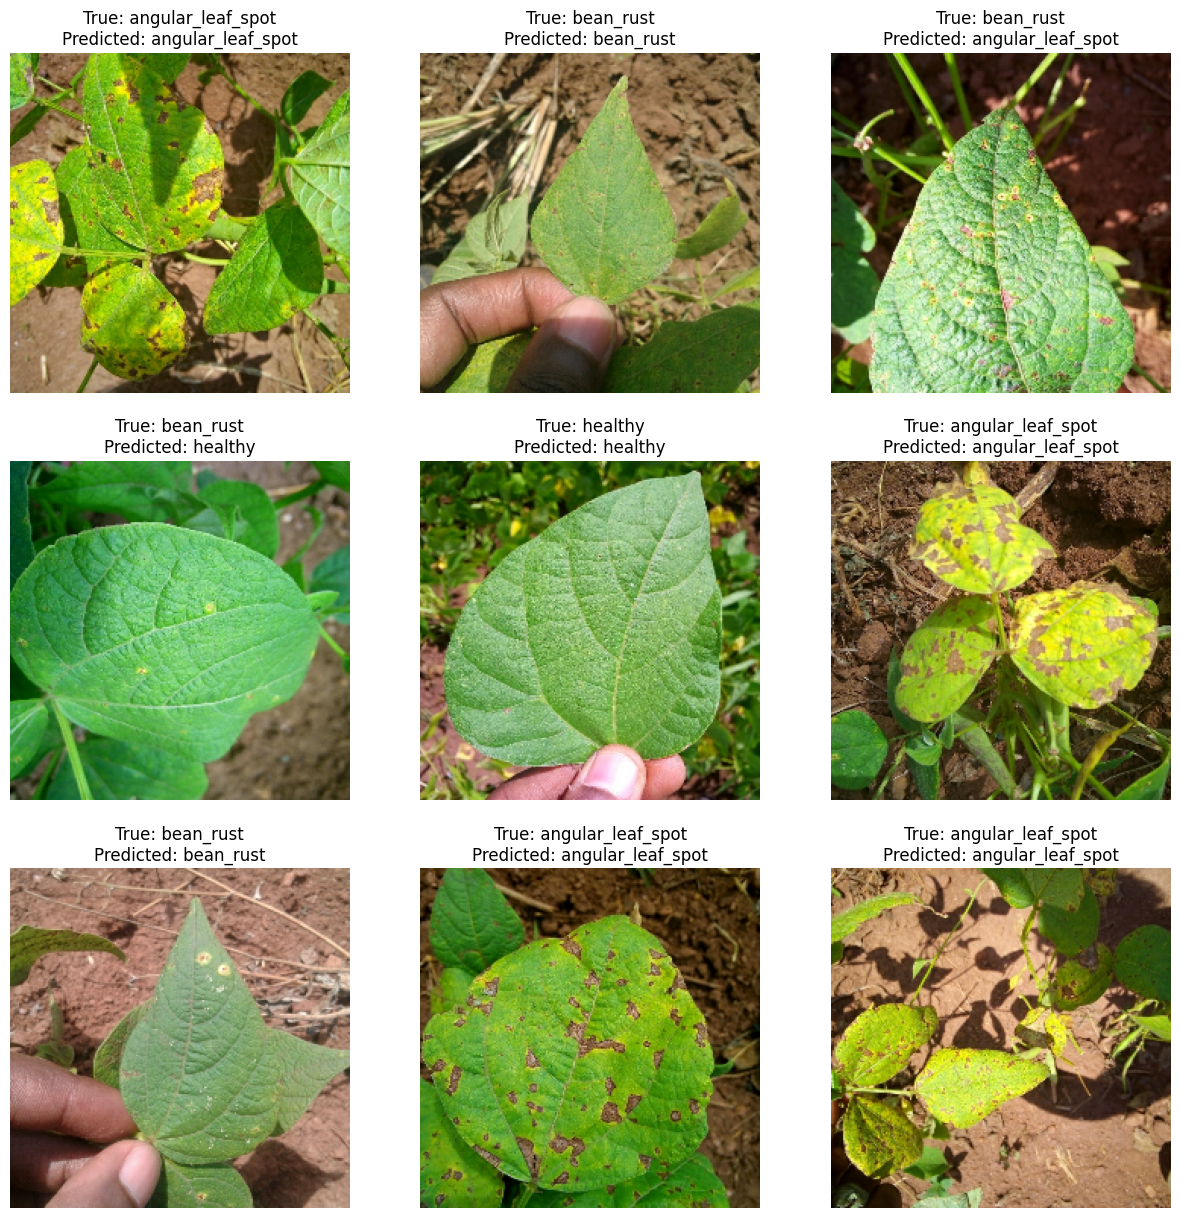

In [ ]:
# Visualize the Results on Test Samples
plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].numpy())
    predicted_label = class_names[tf.argmax(predictions[i])]
    true_label = class_names[test_labels[i].numpy()]
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis("off")
plt.show()

# Model Evaluation

In [ ]:
# Model Evaluation
loss, accuracy = model.evaluate(ds_test)
print(f"Test Accuracy: {accuracy:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9135 - loss: 0.1926
Test Accuracy: 0.91


In [ ]:
# Calculate additional metrics
y_pred = np.argmax(model.predict(ds_test), axis=1)
y_true = np.concatenate([y for x, y in ds_test], axis=0)

print(classification_report(y_true, y_pred, target_names=ds_info.features['label'].names))

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
                   precision    recall  f1-score   support

angular_leaf_spot       0.84      0.98      0.90        43
        bean_rust       0.94      0.79      0.86        43
          healthy       0.98      0.98      0.98        42

         accuracy                           0.91       128
        macro avg       0.92      0.91      0.91       128
     weighted avg       0.92      0.91      0.91       128



# Model Saving And Reusability



In [ ]:
# Model Saving and Download
model.save("beans_model.keras")

In [ ]:
from google.colab import files
files.download("beans_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>